In [1]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import os

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d

from kan import *
from use_training_set import *
import use_KAN
# from use_KAN import *


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
cpu = torch.device('cpu')
device = cpu

## load model

In [3]:
# fname_setup = 'setup_model_13_9.txt'
string_setting = "10-1_8_g_12_16"
# string_setting = "9_7_g_16_16_cos"
fname_setup = f'setup_model_{string_setting}.txt'
with open(fname_setup, 'r') as file:
    config = yaml.safe_load(file)
  
use_KAN.update_device(device)  
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)
# model_KAN = use_KAN.build_model_cos(config['Model Setup'], device=device)

Device set to: cpu
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


### load training set

In [4]:
config_file = 'setup_ts.txt'
x_train, y_train, Q_train = load_training_data(config_file, extend=True, sm=True)
print(x_train.shape)
print(y_train.shape)
x_train_torch = use_KAN.to_torch_device(x_train, device=device)
y_train_torch = use_KAN.to_torch_device(y_train, device=device)
I_train = np.exp(y_train)

logk_z = x_train[:, 0]
k_z = np.exp(logk_z)
# logk_z = np.log(k_z)
alpha = x_train[:, 2]
logkappa = x_train[:, 1]
kappa = np.exp(logkappa)
# logkappa = np.log(kappa)
set_k_z = np.unique(logk_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique((logkappa)))


k_z in
[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   2.   3.   4.   5.
  6.   7.   8.   9.  10. ]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]
(4000, 3)
(4000, 126)


In [5]:
## use the log_Q background model
# Qx = np.vstack([Q_train, np.ones_like(Q_train)]).T
# Qx = np.vstack([np.log(Q_train), np.ones_like(Q_train)]).T
# f_Qx = lambda Q: np.vstack([np.log(Q),np.ones_like(Q)]).T
f_Qx = lambda Q: np.vstack([Q,np.ones_like(Q)]).T
# f_Qx = lambda Q: np.vstack([np.cos(2*np.pi*Q/1),np.cos(2*np.pi*Q/2),np.cos(2*np.pi*Q/4),np.cos(2*np.pi*Q/8),np.cos(2*np.pi*Q/16), np.ones_like(Q)]).T
use_KAN.update_Qx(f_Qx=f_Qx, config=config)

Qx and Qx_inv have been defined and updated.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Model has been redefined.


### load trained model parameters

In [6]:
# fname_BR = "./saved_model/KAN/model_13_9_grid_ft_lin_monoc.pth"
fname_BR = f"./saved_model/KAN/model_{string_setting}.pth"
model_KAN.load_state_dict(torch.load(fname_BR))

<All keys matched successfully>

In [9]:
f_IQ_KAN = lambda model, x, Q: use_KAN.f_IQ_KAN(model, x, Q, f_Qx=f_Qx)
model_output = f_IQ_KAN(model_KAN, x_train_torch, Q_train)

## Plot KAN

In [65]:
from matplotlib.path import Path
from scipy.interpolate import CubicSpline
from scipy.special import comb

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

In [149]:
def plot_kan(kan_to_plot, scale = 0.99, color_input = 'r', color_output = 'r', color_f = 'b'):
    width = np.array(kan_to_plot.width)
    width_in = np.array(kan_to_plot.width_in)
    width_out = np.array(kan_to_plot.width_out)
    A = 1
    y0 = 0.3
    z0 = 0.1

    neuron_depth = len(width)
    min_spacing = A / np.maximum(np.max(width_out), 5)

    max_neuron = np.max(width_out)
    max_num_weights = np.max(width_in[:-1] * width_out[1:])
    y1 = 0.4 / np.maximum(max_num_weights, 5)
    y2 = 0.15 / np.maximum(max_neuron, 5)

    fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * (y0 + z0)))

    for l in range(neuron_depth):
        color = 'k'
        if l == 0:
            color = color_input
        if l == neuron_depth - 1:
            color = color_output

        n = width_in[l]

        for i in range(n):
            plt.scatter(1 / (2 * n) + i / n, l * (y0 + z0), s=min_spacing ** 2 * 10000 * scale ** 2, color=color, zorder=20)

        for i in range(n):
            if l < neuron_depth - 1:
                n_next = width_out[l + 1]
                N = n * n_next
                for j in range(n_next):
                    id_ = i * n_next + j

                    control_point1 = np.array([1 / (2 * n) + i / n, l * (y0 + z0) + 4 * y0 / 5])
                    control_point2 = np.array([1 / (2 * n_next) + j / n_next, l * (y0 + z0) + y0 / 5])
                    path_data = np.array([
                        (1 / (2 * n) + i / n, l * (y0 + z0)),
                        control_point1,
                        control_point2,
                        (1 / (2 * n_next) + j / n_next, l * (y0 + z0) + y0)
                    ])
                    x, y = bezier_curve(path_data)

                    ax.plot(x, y, color=color_f, lw=1 * scale, alpha=1)

        if l < neuron_depth - 1:
            n_in = width_out[l + 1]
            n_out = width_in[l + 1]
            mult_id = 0
            for i in range(n_in):
                if i < width[l + 1][0]:
                    j = i
                else:
                    if i == width[l + 1][0]:
                        if isinstance(kan2.mult_arity, int):
                            ma = kan_to_plot.mult_arity
                        else:
                            ma = kan_to_plot.mult_arity[l + 1][mult_id]
                        current_mult_arity = ma
                    if current_mult_arity == 0:
                        mult_id += 1
                        if isinstance(kan2.mult_arity, int):
                            ma = kan_to_plot.mult_arity
                        else:
                            ma = kan_to_plot.mult_arity[l + 1][mult_id]
                        current_mult_arity = ma
                    j = width[l + 1][0] + mult_id
                    current_mult_arity -= 1
                plt.plot([1 / (2 * n_in) + i / n_in, 1 / (2 * n_out) + j / n_out], [l * (y0 + z0) + y0, (l + 1) * (y0 + z0)], color='black', lw=2 * scale)

            N = n = width_out[l + 1]
            for j in range(n):
                plt.plot(1 / (2 * n) + j / n, (l + 1) * (y0 + z0) - z0, 'ow', fillstyle='full', ms=15* scale)
                plt.plot(1 / (2 * n) + j / n, (l + 1) * (y0 + z0) - z0, 'ok', fillstyle='none', ms=15* scale)
                plt.plot(1 / (2 * n) + j / n, (l + 1) * (y0 + z0) - z0, '+k', fillstyle='none', ms=12* scale)

            plt.xlim(0, 1)
            plt.ylim(-0.1 * (y0 + z0), (neuron_depth - 1 + 0.1) * (y0 + z0))
            plt.axis('off')

    plt.show()

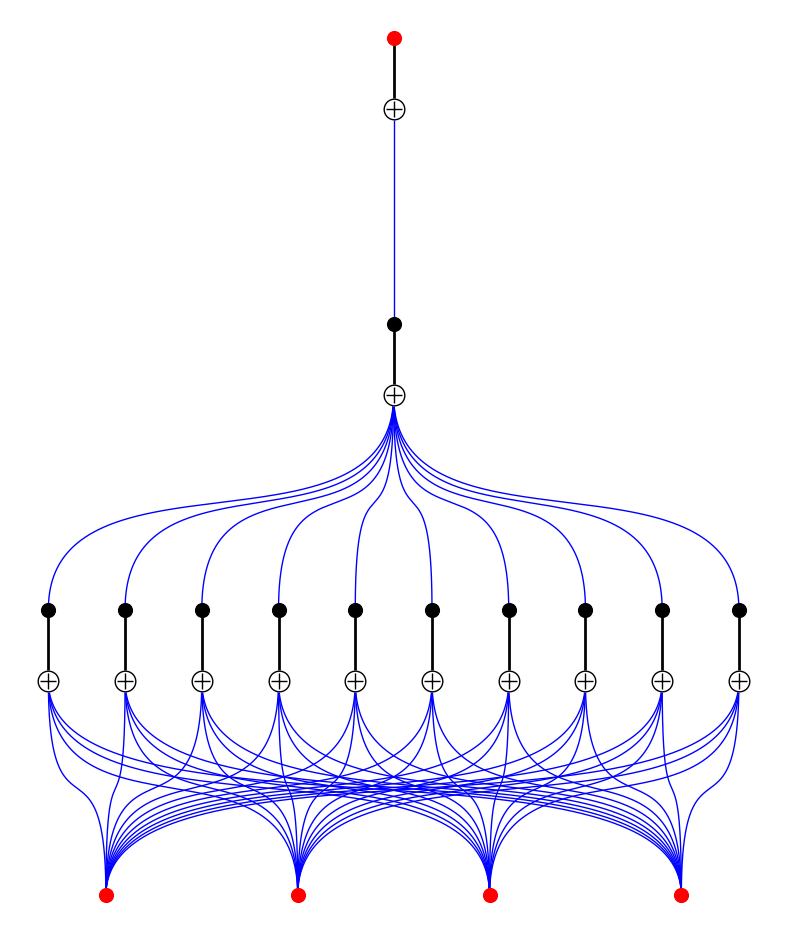

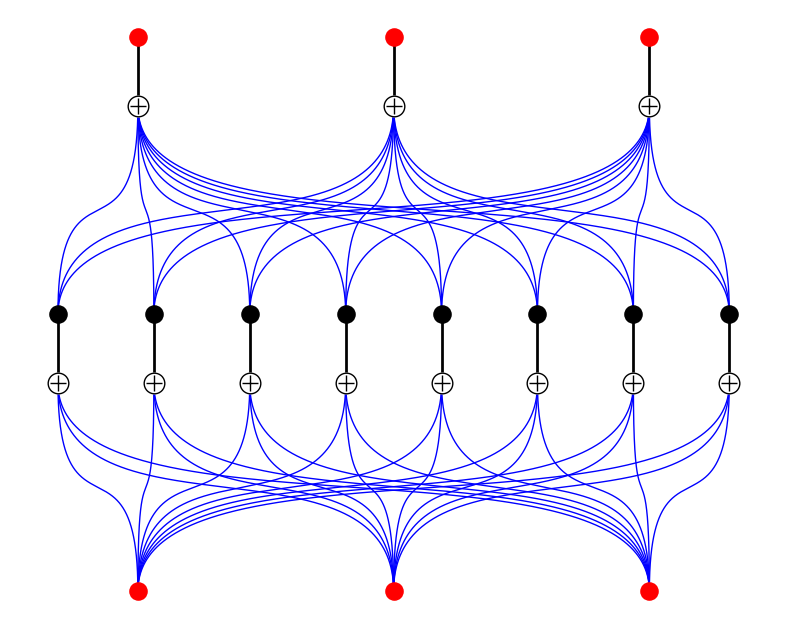

In [150]:
plot_kan(model_KAN.kan)
plot_kan(model_KAN.kan_aug)